<a href="https://colab.research.google.com/github/iLikeKatz/MyLeaning_ML/blob/main/PytorchFullCourse/Models/Computer_Vision(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
import pandas as pd
import numpy as np

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data = torchvision.datasets.FashionMNIST(root="Data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST(root="Data", train=False, download=True, transform=transforms.ToTensor())
image, label = train_data[0]

classes_name = train_data.classes
n_classes = len(train_data.classes)
n_classes, image.shape

(10, torch.Size([1, 28, 28]))

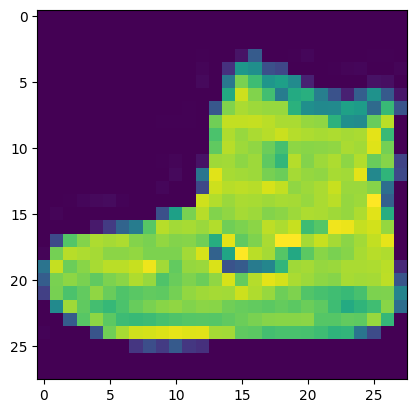

In [11]:
plt.imshow(image.reshape(28, 28, 1)) #since pytorch default set color channels at the fist of shape but plt require color channles at last position of shape
plt.show()

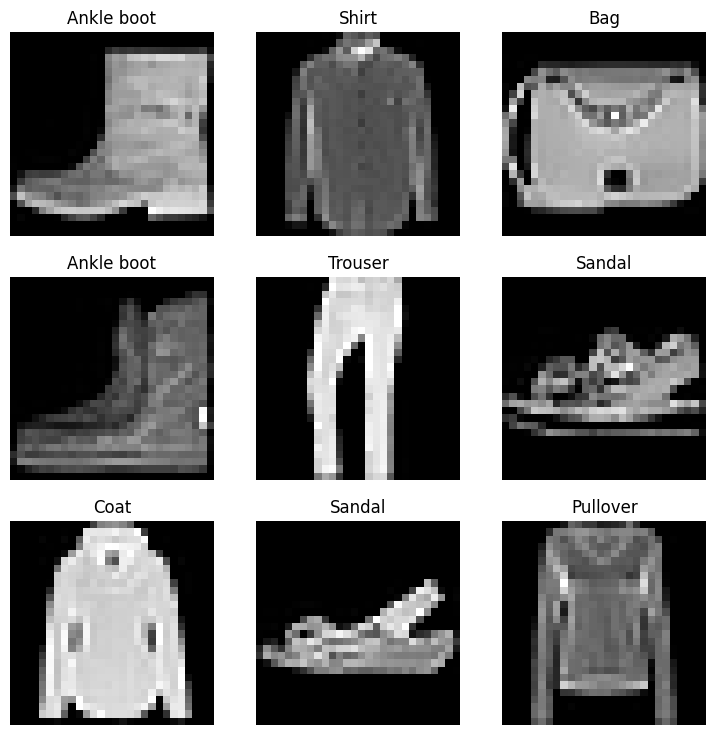

In [12]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, (rows*cols)+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.reshape(28, 28, 1), cmap='gray')
  plt.title(classes_name[label])
  plt.axis(False)

In [13]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

train_features_batch, train_label_batch = next(iter(train_dataloader))
test_features_batch, train_label_batch = next(iter(test_dataloader))

f = nn.Flatten()
n_classes = len(train_label_batch.unique())
n_features = f(train_features_batch).shape[1]
n_channels = train_features_batch.shape[1]
n_features, n_classes, n_channels


(784, 10, 1)

In [14]:
#Flatten
x = train_features_batch[0]
f = nn.Flatten()

x = f(x)
x.shape # x -> [color_channels, h*w] since because nn.Linear can't handle high dimens data

torch.Size([1, 784])

In [17]:
class fashionMNIST(nn.Module):
  def __init__(self, in_features, out_features, hidden=10):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_features, hidden, kernel_size=3, stride=1, padding=1), #it's different here if we use cnn, the in_features gotta be color channels
        nn.ReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3,  stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, out_features) #if you ask me why this is 7 it's because we start at 1, 28, 28 and through maxpool1 then it'll become 1, 14, 14 and in the last it through maxpool2 and it became 1, *7, 7* here is the point i know you'll understand
        #if you ask again why it became 14 from 28 and 7 from 14, well, it because we've set maxpool kernel_size = 2, so it's simply maxpool gonna reduce our shape = shape/kernel_size, = 28/2 = 14, 14/2 = 7
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

model = fashionMNIST(n_channels, n_classes, hidden=60).to(device)

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 3

dummy = torch.rand(1, 1, 28, 28) # 28 -> 14 -> 7, in -> process, it though maxpool and delete some trashs of features so shape is reduced
y_pred = model(dummy.to(device))
y_pred

tensor([[-0.9878,  0.3168, -0.6510, -0.8709, -0.9997, -0.0826,  1.8478, -2.1310,
          3.2778,  0.4291]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
startTime = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch+1}/{epochs}\n-----")
  loss_train = 0
  for batch, (x, y) in enumerate(train_dataloader):
    model.train()
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss_train += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch %  400 == 0:
      print(f"looked at {batch*len(x)}/{len(train_dataloader.dataset)}, ")

  loss_train /= len(train_dataloader)

  model.eval()
  loss_test, test_acc = 0, 0
  with torch.inference_mode():
    for x_test, y_test in test_dataloader:
      x_test, y_test = x_test.to(device), y_test.to(device)
      test_pred = model(x_test)
      loss_test += loss_fn(test_pred, y_test)

      test_acc += acc(y_test.cpu(), test_pred.argmax(dim=1).cpu())

    loss_test /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"train loss : {loss_train:.4f} | test loss : {loss_test:.4f} | test acc : {test_acc*100}")

endTime = timer()
total_train_time = endTime - startTime
f"total time : {total_train_time:.4f} sec"

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 1/3
-----
looked at 0/60000, 
looked at 12800/60000, 
looked at 25600/60000, 
looked at 38400/60000, 
looked at 51200/60000, 
train loss : 0.5509 | test loss : 0.3534 | test acc : 87.40015974440894
Epoch : 2/3
-----
looked at 0/60000, 
looked at 12800/60000, 
looked at 25600/60000, 
looked at 38400/60000, 
looked at 51200/60000, 
train loss : 0.3165 | test loss : 0.3041 | test acc : 89.12739616613419
Epoch : 3/3
-----
looked at 0/60000, 
looked at 12800/60000, 
looked at 25600/60000, 
looked at 38400/60000, 
looked at 51200/60000, 
train loss : 0.2740 | test loss : 0.2866 | test acc : 89.8861821086262


'total time : 41.6997 sec'

In [24]:
def eval_model(model, dataloader, loss_fn, accuracy_fn, device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x,y in dataloader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y.cpu(), y_pred.argmax(dim=1).cpu())

    loss /= len(dataloader)
    acc /= len(dataloader)

  return {"model_name : " : model.__class__.__name__,
              "model_loss" : loss.item(),
              "model_acc" : acc*100
          }

In [25]:
model_result = eval_model(model, test_dataloader, loss_fn, acc, device)
model_result

{'model_name : ': 'fashionMNIST',
 'model_loss': 0.28661641478538513,
 'model_acc': 89.8861821086262}

In [26]:
def train_model(model, dataloader, loss_fn, accuracy_fn, device=device):
  loss_train, acc = 0, 0
  for x, y in dataloader:
    model.train()
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    loss_train += loss
    acc += accuracy_fn(y.cpu(), y_pred.argmax(dim=1).cpu())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_train /= len(dataloader)
  acc /= len(dataloader)

  return {"loss_train" : loss_train.item(),
              "acc" : acc*100
          }

In [27]:
model_train = train_model(model, train_dataloader, loss_fn, acc, device)
model_train

{'loss_train': 0.24796906113624573, 'acc': 91.04166666666667}

In [57]:
import random
test_sample = []
test_label = []

for sample, label in random.sample(list(test_data), k=9):
  test_sample.append(sample)
  test_label.append(label)

In [58]:
pred_probs = []
with torch.inference_mode():
  for x in test_sample:
    x, y = x.to(device), y.to(device)
    y_pred  = model(x.unsqueeze(0))
    y_pred = torch.softmax(y_pred.squeeze(), dim=0)
    pred_probs.append(y_pred.cpu())

  pred_probs = torch.stack(pred_probs)
pred_probs.shape

torch.Size([9, 10])

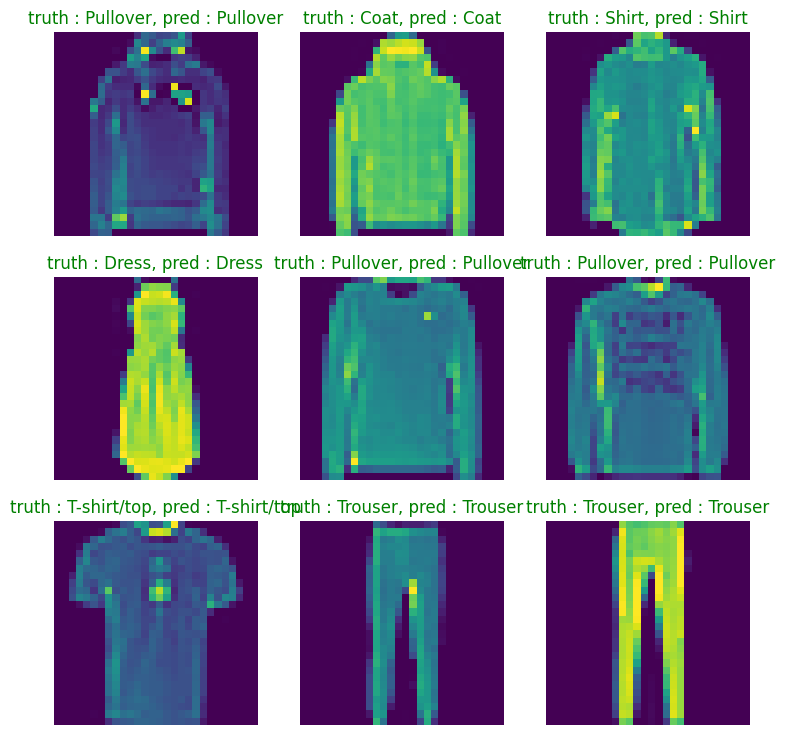

In [59]:
pred_classes = pred_probs.argmax(1)

plt.figure(figsize=(9, 9))
row, col = 3, 3
for i, sample in enumerate(test_sample):
  plt.subplot(row, col, i+1)
  plt.imshow(sample.squeeze())
  pred_label = classes_name[pred_classes[i]]
  tru_label = classes_name[test_label[i]]
  text = f"truth : {tru_label}, pred : {pred_label}"
  plt.axis(False)

  if pred_label == tru_label:
    plt.title(text, c='green')
  else :
    plt.title(text, c='red')